# Notebook to perform data splitting for train/test & val
We plan to use a single train/test data set as our models will use cross validation in order to train, which should help give some idea of how well the model generalizes initially. 

In [134]:
# to do - get this to loop over all the datasets. 

In [135]:
import pandas as pd
from rdkit import Chem
from sklearn.model_selection import train_test_split

from rdkit.Chem import AllChem
import numpy as np
from tqdm import tqdm
import os
import umap
import seaborn as sns
import matplotlib.pyplot as plt
tqdm.pandas()
np.random.seed(0)

In [136]:
path='data_cleaned'
out_path='data_split_cleaned'

files=os.listdir(path)
data_map={
    'HIV.csv': {'target':'HIV_active','structure':'smiles'},
    'bace.csv':{'target':'active','structure':'mol'},
    'tox21.csv':{'target':'NR-AhR','structure':'smiles'},
    'clintox.csv':{'target':'CT_TOX','structure':'smiles'},
    'sol_del.csv':{'target':'binned_sol','structure':'smiles'},
    'deepchem_Lipophilicity.csv':{'target':'drug_like','structure':'smiles'}   
}

validation_size=0.15

In [137]:
# test file
files = os.listdir(path)

df=pd.read_csv(os.path.join(path,'bace.csv'))

In [138]:
def generate_fingerprint(smiles,radius,bits):
    try:
        mol=Chem.MolFromSmiles(smiles)
        fp=AllChem.GetMorganFingerprintAsBitVect(mol,radius,bits)
        return(np.array(fp))
    except:
        print(f'{smiles} failed in RDkit')
        return (np.nan)

In [139]:
# Generate the morgan finger prints and drop any rows that don't convert to a mol, or those that don't have a target value
radius=2
bits=1024
df['fp'] = df['mol'].apply(lambda x: generate_fingerprint(x,radius,bits))
df.dropna(subset=['fp','active'],inplace=True)

# Random split:

In [140]:
df_train, df_validate = train_test_split(df,test_size=validation_size,random_state=0)

In [141]:
print(df_train.shape)
print(df_train['active'].value_counts())
#df_train.head(2)

(1286, 598)
1    856
0    430
Name: active, dtype: int64


In [142]:
print(df_validate.shape)
print(df_validate['active'].value_counts())
#df_validate.head(2)

(227, 598)
1    156
0     71
Name: active, dtype: int64


In [143]:
dataset='bace'
df_train.to_csv(os.path.join(out_path,f'{dataset}_train.csv'))
df_validate.to_csv(os.path.join(out_path,f'{dataset}_validate.csv'))

# Clustered Split
To make the split more realistic and understand how well the model will generalize to new data, let's also look at a split based on the data clusters. The goal is to minimize overlap in terms of chemical structure between the two data sets. This will effectively make it much harder for a model that just memorizes certain aspects of the potent scaffolds for instance.<br>
This code was inspired by the chemprop scaffold based split: https://chemprop.readthedocs.io/en/latest/_modules/chemprop/data/scaffold.html

In [144]:
from sklearn.cluster import MiniBatchKMeans
clusters=int(df.shape[0]/30)
kmeans = MiniBatchKMeans(n_clusters=clusters,random_state=0,batch_size=100).fit(df['fp'].to_list())

In [145]:
df['cluster']=kmeans.labels_

In [146]:
df['cluster'].value_counts()

9     157
25     82
7      79
8      75
12     67
36     67
39     62
3      57
27     54
34     47
35     45
18     37
16     36
49     36
48     35
10     34
5      33
30     33
33     33
17     30
19     29
6      28
32     28
22     27
38     25
26     24
13     21
40     20
14     18
28     18
46     16
43     15
42     15
23     15
2      14
20     12
15     11
37     10
4      10
45      9
31      8
44      8
1       8
47      7
0       4
29      4
21      4
24      2
41      2
11      2
Name: cluster, dtype: int64

In [14]:
# add these clusters to two groups, train and val:
val_size=validation_size*len(df)
df_cluster_train=pd.DataFrame()
df_cluster_val=pd.DataFrame()
for group, dataframe in df.groupby('cluster'):
    if dataframe.shape[0] > val_size / 2:
        df_cluster_train=pd.concat([df_cluster_train,dataframe])
    elif len(df_cluster_val)+len(dataframe) <= val_size:
        df_cluster_val=pd.concat([df_cluster_val,dataframe])
    else:
        df_cluster_train=pd.concat([df_cluster_train,dataframe])
        

In [15]:
print(df_cluster_train.shape)
print(df_cluster_train['active'].value_counts())

(1287, 599)
1    845
0    442
Name: active, dtype: int64


In [16]:
print(df_cluster_val.shape)
print(df_cluster_val['active'].value_counts())

(226, 599)
1    167
0     59
Name: active, dtype: int64


In [17]:
# class balance is a little different between the two, however this should outweigh issues arising from
# the scaffolds being shared between both. 

In [18]:
845/(845+442)

0.6565656565656566

In [19]:
167/(167+59)

0.7389380530973452

In [21]:
# chemical space Umapping adapted from: https://blog.reverielabs.com/mapping-chemical-space-with-umap/

import umap

umap_model = umap.UMAP(metric = "jaccard",
                      n_neighbors = 25,
                      n_components = 2,
                      low_memory = False,
                      min_dist = 0.001)
X_umap = umap_model.fit_transform(df['fp'].to_list())
df["UMAP_0"], df["UMAP_1"] = X_umap[:,0], X_umap[:,1]

/opt/anaconda3/envs/Capstone/lib/python3.10/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(


<AxesSubplot:xlabel='UMAP_0', ylabel='UMAP_1'>

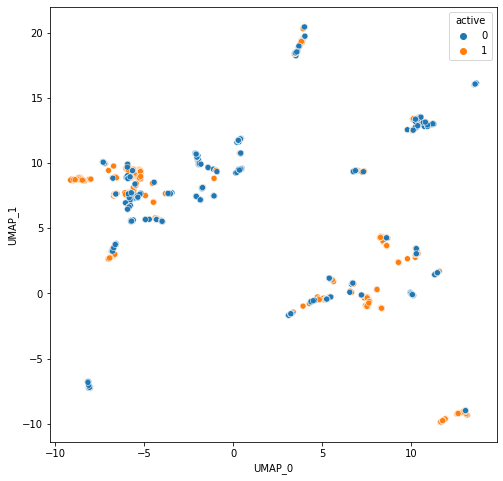

In [29]:
fig, ax = plt.subplots(figsize=(8,8))
sns.scatterplot(data=df,x='UMAP_0',y='UMAP_1',hue='active',ax=ax)

In [74]:
cluster_balance={'cluster':[],'active':[],'inactive':[],'size':[]}
for group, dataframe in df.groupby('cluster'):
    cluster_balance['cluster'].append(group)
    try:
        actives = dataframe['active'].value_counts()[1]
    except:
        actives = 0 
    try:    
        inactives=dataframe['active'].value_counts()[0]
    except:
        inactives=0
    cluster_balance['active'].append(actives)
    cluster_balance['inactive'].append(inactives)
    cluster_balance['size'].append(actives+inactives)
cluster_df=pd.DataFrame(cluster_balance).sort_values(by='size',ascending=False)
cluster_df['ratio']=cluster_df['active']/(cluster_df['inactive']+cluster_df['active'])
print(cluster_df.shape)
cluster_df.head(20)

(50, 5)


,cluster,active,inactive,size,ratio
9,9,54,103,157,0.343949
25,25,78,4,82,0.951220
7,7,50,29,79,0.632911
8,8,67,8,75,0.893333
36,36,64,3,67,0.955224
12,12,66,1,67,0.985075
39,39,27,35,62,0.435484
3,3,57,0,57,1.000000
27,27,23,31,54,0.425926
34,34,46,1,47,0.978723


Text(0.5, 1.0, 'Cluster balance')

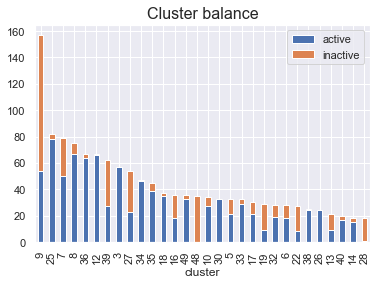

In [79]:
# plot cluster balance:
sns.set()
plot_df=cluster_df[['cluster','active','inactive']].iloc[0:30]
plot_df.set_index('cluster').plot(kind='bar', stacked=True)

#add overall title
plt.title('Cluster balance', fontsize=16)


Text(0, 0.5, 'fraction of actives')

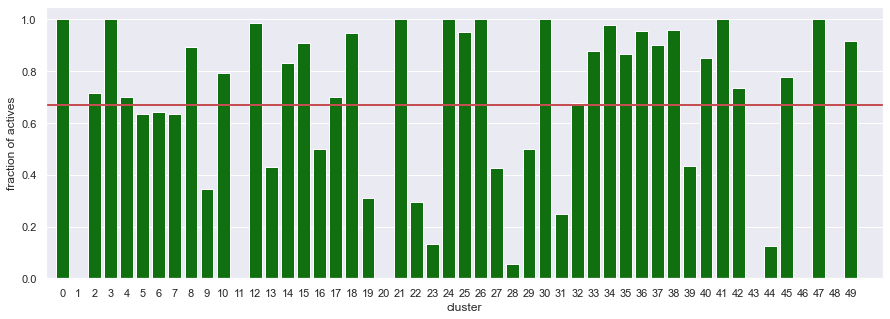

In [125]:
#possible way to show that many of the clusters are skewed towards the postive or negative class:
fig, ax = plt.subplots(figsize=(15,5))
cluster_df=cluster_df.sort_values(by='ratio')
cluster_df.reset_index(inplace=True,drop=True)
sns.barplot(data=cluster_df,x='cluster',y='ratio',ax=ax,color='green')

mean_balance= cluster_df['active'].sum()/(cluster_df['active'].sum()+cluster_df['inactive'].sum())
ax.hlines(y=mean_balance, xmin=-1, xmax=51, linewidth=2, color='r')
ax.set_xlim(-1,51)
ax.set_ylabel('fraction of actives')

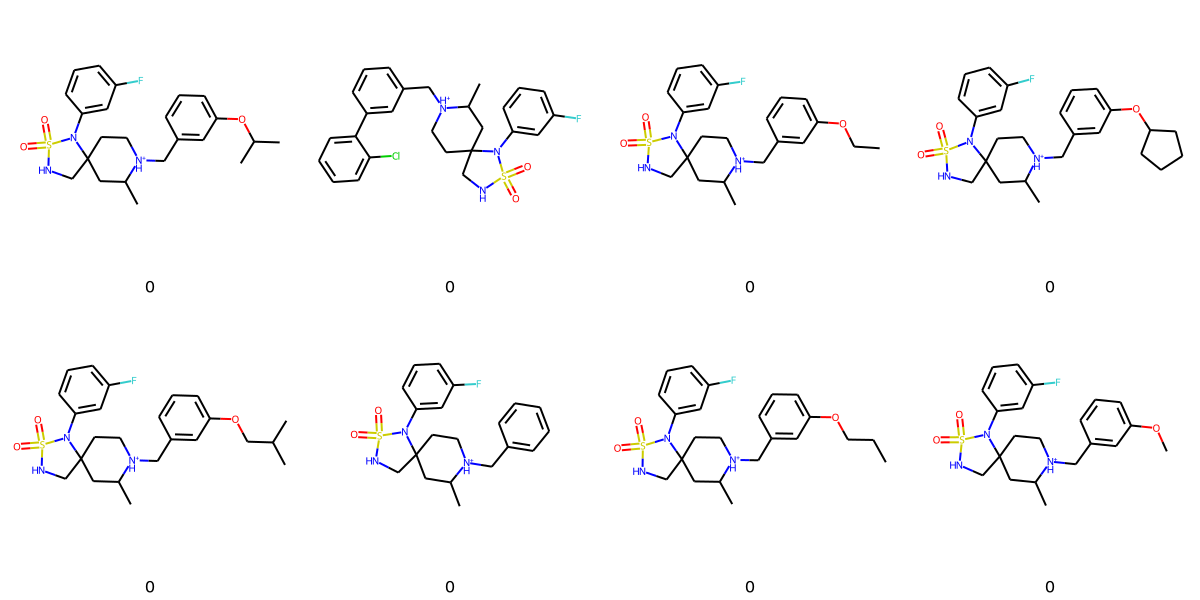

In [126]:
# look into highlight substructures: https://www.rdkit.org/docs/Cookbook.html

from rdkit import Chem
from rdkit.Chem import Draw
# Example of a negative cluster:
mols=[]
cluster=1
df_filter=df[df['cluster']==cluster]
smiles=df_filter['mol'].to_list()
actives=df_filter['active'].to_list()
mols=[Chem.MolFromSmiles(smile) for smile in smiles]
i=0
for mol in mols:
    mol.SetDoubleProp('active',actives[i])
    i+=1

Draw.MolsToGridImage(mols,molsPerRow=4,subImgSize=(300,300),legends=[x.GetProp("active") for x in mols])

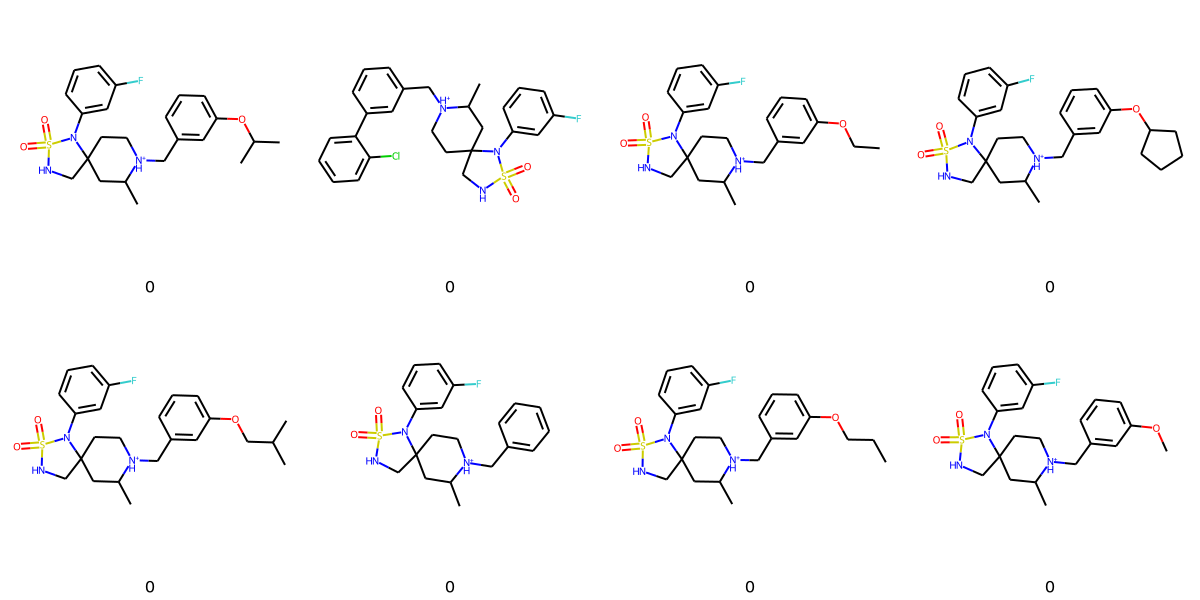

In [132]:
# Example of a postive cluster:
mols=[]
cluster=1
df_filter=df[df['cluster']==cluster]
smiles=df_filter['mol'].to_list()
actives=df_filter['active'].to_list()
mols=[Chem.MolFromSmiles(smile) for smile in smiles]
i=0
for mol in mols:
    mol.SetDoubleProp('active',actives[i])
    i+=1

Draw.MolsToGridImage(mols,molsPerRow=4,subImgSize=(300,300),legends=[x.GetProp("active") for x in mols])

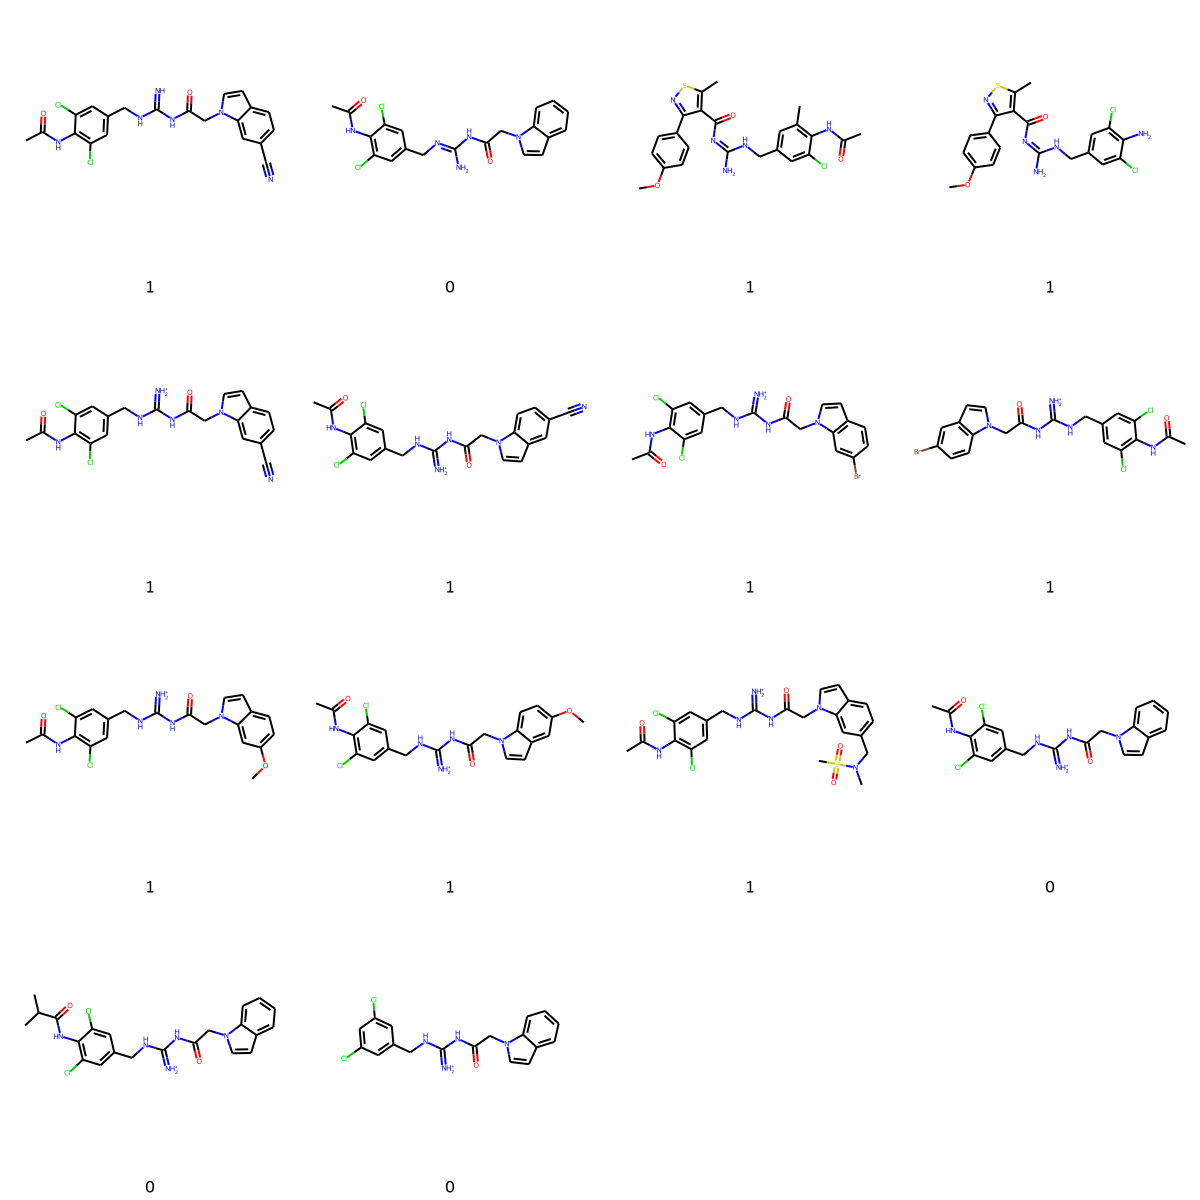

In [133]:
# Example of a mixed cluster:
mols=[]
cluster=2
df_filter=df[df['cluster']==cluster]
smiles=df_filter['mol'].to_list()
actives=df_filter['active'].to_list()
mols=[Chem.MolFromSmiles(smile) for smile in smiles]
i=0
for mol in mols:
    mol.SetDoubleProp('active',actives[i])
    i+=1

Draw.MolsToGridImage(mols,molsPerRow=4,subImgSize=(300,300),legends=[x.GetProp("active") for x in mols])

In [139]:
dataset='bace'
df_cluster_train.to_csv(os.path.join(out_path_cluster,f'{dataset}_cluster_train.csv'))
df_cluster_val.to_csv(os.path.join(out_path_cluster,f'{dataset}_cluster_validate.csv'))

# Apply this splitting to all of the datasets:

In [ ]:
# setup loop to split datasets

for file in files:
    if file[-4:]=='.csv':
        print(file)
        dataset_name=file.replace('.csv','')
        df=pd.read_csv(os.path.join(path,file))
        # extract the dataset features:
        target=data_map[file]['target']
        smiles=data_map[file]['structure']
        # add a copy of the target_columns:
        df['target_actual']=df[target]
        # add the features:
        radius=2
        bits=1024
        df['fp'] = df[smiles].apply(lambda x: generate_fingerprint(x,radius,bits))
        df.dropna(subset=['fp',target],inplace=True)
        
        #perform a random split:
        df_train, df_validate = train_test_split(df,test_size=validation_size,random_state=0)
        df_train.to_csv(os.path.join(out_path,f'{dataset_name}-random-train.csv'))
        df_validate.to_csv(os.path.join(out_path,f'{dataset_name}-random-validate.csv'))
        
        # perform the clusterd split:
        clusters=int(df.shape[0]/30) # generate a rough number of clusters
        kmeans = MiniBatchKMeans(n_clusters=clusters,random_state=0,batch_size=100).fit(df['fp'].to_list())
        df['cluster']=kmeans.labels_
        # add these clusters to two groups, train and val:
        val_size=validation_size*len(df)
        df_cluster_train=pd.DataFrame()
        df_cluster_val=pd.DataFrame()
        
        for group, dataframe in df.groupby('cluster'):
            if dataframe.shape[0] > val_size / 2:
                df_cluster_train=pd.concat([df_cluster_train,dataframe])
            elif len(df_cluster_val)+len(dataframe) <= val_size:
                df_cluster_val=pd.concat([df_cluster_val,dataframe])
            else:
                df_cluster_train=pd.concat([df_cluster_train,dataframe])
        # write the clustered sets to a file:
        df_cluster_train.to_csv(os.path.join(out_path,f'{dataset_name}-cluster-train.csv'))
        df_cluster_val.to_csv(os.path.join(out_path,f'{dataset_name}-cluster-validate.csv'))

deepchem_Lipophilicity.csv
sol_del.csv
HIV.csv


[17:49:19] WARNING: not removing hydrogen atom without neighbors
[17:49:19] WARNING: not removing hydrogen atom without neighbors
